In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2

In [2]:
import autoreload
# sys.path.append(r'C:\Users\XXX\PycharmProjects\kNN_function')
from Frames_Alignment import *
%load_ext autoreload
%autoreload 2

## 获取剪裁后的人脸

In [3]:
# 改成自己本地电脑上的视频路径
video_file = './Test_Videos/stable1.mp4'
span = 10

# 自然指标，从1开始
frames = get_frames_through_idx(video_file,1,15,800,resize=False)
print(len(frames))
print(frames[0].shape)

batch_of_face_locations,batch_of_landmarks,num_chin,num_eye = get_location_landmark(frames,0)

#  关键点滤波
batch_of_filtered_landmarks = landmarks_filter(batch_of_landmarks,span)
frames = np.array(frames)

#  旋转帧使人脸水平
rotated_frames, eye_centers, angles = rotate_face(frames, batch_of_filtered_landmarks, num_chin, num_eye)

#  旋转关键点
rotated_landmarks = rotate_landmarks(eye_centers, batch_of_filtered_landmarks, angles)

#  把人脸剪裁出来
cropped_frames,lefts,tops = crop_face(rotated_frames, eye_centers, rotated_landmarks)

#  关键点坐标变换
transferred_landmarks = transfer_landmark(rotated_landmarks, lefts, tops)

#  去除非皮肤区域
skin_frames,skin_masks = extract_Skin_YCrCb_Otsu(cropped_frames)

15
(960, 544, 3)


## ROI切割及信号提取方式一：深度可分离卷积，缺点是TensorFlow暂时不支持很灵活的步长选择，但运算速度极快

In [4]:
def channel_1D_signal_Conv2D(frames,masks):
    """
    利用卷积的特性来一步同时进行区域划分以及求得区域像素平均值，很方便，但是目前tensorflow还不支持滑动步长不等的操作，
    所以只能强行规定步长一致，这样造成的结果是每一批帧卷积后的ROI数目会不同，因此这种方式舍弃，不使用，但留着说不定日后能用。
    params:
    frames:shape=batch,h,w,c
    masks:shape=batch,h,w,1，由0和1构成
    
    return:
    frames:shape=batch,h_roi,w_roi,3
    """
    frames = tf.convert_to_tensor(frames,dtype=tf.float32)
    masks = tf.convert_to_tensor(masks,dtype=tf.float32)
    
    kernel_size = np.ceil(np.array(frames.shape[1:3])/5).astype(np.int32)
    strides = (kernel_size[0],kernel_size[0])
    DepthConv_frame = keras.layers.DepthwiseConv2D(kernel_size=kernel_size,strides=strides,padding='same',\
                                                   depthwise_initializer='ones',use_bias=False)
    DepthConv_mask = keras.layers.DepthwiseConv2D(kernel_size=kernel_size,strides=strides,padding='same',\
                                                   depthwise_initializer='ones',use_bias=False)
    
    frames = DepthConv_frame(frames)  # eg. shape:(10, 5, 5, n_channel)
    masks = DepthConv_mask(masks)  # eg. shape:(10, 5, 5, 1)
    frames = frames / masks
    
    return frames.numpy(),masks.numpy()

## ROI切割及信号提取方式二：人为规定切割方式并逐个计算区域像素平均值，缺点是速度慢，但能保证数据一致性

In [5]:
def draw_ref_grid(frame,w_density=5,h_density=5):
    """
    在人脸上绘制网格
    frame:shape:h*w*n_channel
    """
    frame = np.squeeze(frame)
    H,W = frame.shape[:2]
    h,w = np.ceil(np.array(frame.shape[:2])/np.array((h_density,w_density))).astype(np.int32)
    
    # 画竖条纹
    for i in range(w_density):
        pt1 = (min((i + 1) * w,W) - 2,0)
        pt2 = (min((i + 1) * w,W) - 1,H-1)
        cv2.rectangle(frame,pt1,pt2,color=(255,255,255),thickness=-1)
    # 画横条纹
    for i in range(h_density):
        pt1 = (0,min((i + 1) * h,H) - 2)
        pt2 = (W - 1,min((i + 1) * h,H) - 1)
        cv2.rectangle(frame,pt1,pt2,color=(255,255,255),thickness=-1)
    
    cv2.namedWindow("Image with grid")
    cv2.imshow("Image with grid",frame[...,::-1])

    if cv2.waitKey(0):
        cv2.destroyAllWindows()
        
def channel_1D_signal(frames,w_density,h_density,ROI_ids):
    """
    提取指定ROI的一维时间信号
    
    params:
    frames:shape:batch*H*W*n_channel
    w_density:横向分割的密度
    h_density:纵向分割的密度
    ROI_ids:list,ROI的序号
    """
#     frames = np.squeeze(frames)
    H,W = frames.shape[1:3]
    h,w = np.ceil(np.array((H,W))/np.array((h_density,w_density))).astype(np.int32)
    
    signal_1D = []
    for ROI_id in ROI_ids:
        x_id,y_id = ROI_id // w_density,ROI_id % w_density
        
        ROI = frames[:,x_id * h:(x_id + 1) * h,y_id * w:(y_id + 1) * w,:]  # shape:batch*h*w*n_channel
        signal = np.mean(ROI,axis=(1,2))  # shape:batch*n_channel
        signal_1D.append(signal.reshape(signal.shape[0],1,-1))  # shape:batch*1*n_channel
    
    return np.concatenate(signal_1D,axis=1)  # shape:batch*n_ROI*n_channel

In [6]:
#  规定人脸区域分割为7*4=28个区域，这样划分可以将脸颊完整的划分出来
w_density = 7
h_density = 4
ROI_ids = np.arange(w_density * h_density)

#  区域划分展示
draw_ref_grid(skin_frames[0],w_density,h_density)

In [7]:
signal_1D = channel_1D_signal(skin_frames,w_density,h_density,ROI_ids)  #  shape:batch_size*n_ROI*n_channel
print(signal_1D.shape)

(15, 28, 3)


## ROI信号可视化

In [8]:
def display_1D_signal(signal_1D,ROI_ids,channel_id,save=False,save_path=None):
    """
    显示一维的信号
    
    params:
    signal_1D:提取出的1D信号,shape:batch*n_ROI*n_channel
    ROI_ids:list,ROI的序号
    channel_id:要显示的通道id，指标从0开始
    save:要不要保存
    save_path:保存路径
    """
    plt.figure(figsize=(13, 10))
    #  调整子图间距
    plt.subplots_adjust(wspace = 0, hspace = 0.5)
    for idx,ROI_id in enumerate(ROI_ids):
        data = signal_1D[:,idx,channel_id]
        
        ax = plt.subplot(len(ROI_ids),1,idx + 1)
        
#         ax.set_xlabel("ROI {} (row:{} column:{}) signal".format(ROI_id, ROI_id // 4 + 1,ROI_id % 4 + 1))
        ax.set_ylabel("ROI {}".format(ROI_id),fontsize = 15)
        ax.set_title("Channel {} 1D signal".format(channel_id))
        
        xticks = np.arange(1,len(data)+1)
        ax.set_xticks(xticks)
        ax.set_xlim([1,len(data)+1])
        
        yticks = np.arange(min(data)-5,max(data)+5,(max(data)-min(data)+10)/5)
        ax.set_yticks(yticks)
        ax.set_ylim([min(data)-5,max(data)+5])

        x = np.arange(1,len(data)+1,1)
        ax.plot(x,data,"-")
        ax.grid(True)
    plt.show()
    
    if save:
        with open(save_path,'a') as f:
            pass

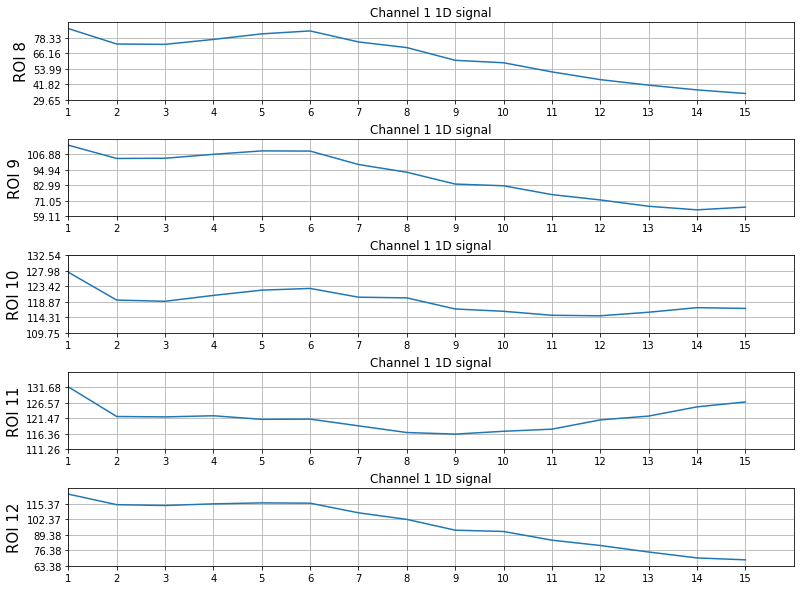

In [9]:
display_1D_signal(signal_1D,[8,9,10,11,12],channel_id=1,save=False,save_path=None)